In [1]:
import afqinsight.nn.tf_models as nn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from afqinsight.datasets import AFQDataset
from afqinsight.nn.tf_models import cnn_lenet, mlp4, cnn_vgg, lstm1v0, lstm1, lstm2, blstm1, blstm2, lstm_fcn, cnn_resnet
from sklearn.impute import SimpleImputer
import os.path
# Harmonization
from sklearn.model_selection import train_test_split
from neurocombat_sklearn import CombatModel
import pandas as pd
from sklearn.utils import shuffle, resample
from afqinsight.augmentation import jitter, time_warp, scaling, magnitude_warp, window_warp
import tempfile
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
afq_dataset = AFQDataset.from_files(
    fn_nodes="../data/raw/combined_tract_profiles.csv",
    fn_subjects="../data/raw/participants_updated_id.csv",
    dwi_metrics=["dki_fa", "dki_md", "dki_mk"],
    index_col="subject_id",
    target_cols=["age", "dl_qc_score", "scan_site_id"],
    label_encode_cols=["scan_site_id"]
)

In [3]:
afq_dataset.drop_target_na()

In [4]:
print(len(afq_dataset.subjects))
print(afq_dataset.X.shape)
print(afq_dataset.y.shape)

1865
(1865, 7200)
(1865, 3)


In [6]:
full_dataset = list(afq_dataset.as_tensorflow_dataset().as_numpy_iterator())

In [7]:
X = np.concatenate([xx[0][None] for xx in full_dataset], 0)
y = np.array([yy[1][0] for yy in full_dataset])
qc = np.array([yy[1][1] for yy in full_dataset])
site = np.array([yy[1][2] for yy in full_dataset])

(array([354.,  70.,  48.,  48.,  50.,  37.,  79.,  93., 176., 910.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

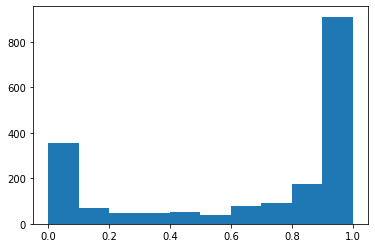

In [8]:
plt.hist(qc)

In [9]:
X = X[qc>0]
y = y[qc>0]
site = site[qc>0]

In [10]:
X.shape

(1817, 100, 72)

In [25]:
def tf_aug(X_in, scaler=1/20):
    X_out = np.zeros_like(X_in)
    for channel in range(X_in.shape[-1]):
        this_X = X_in[..., channel][np.newaxis, ..., np.newaxis]
        scale = np.abs(np.max(this_X) - np.min(this_X)) * scaler
        this_X = jitter(this_X, sigma=scale)
        this_X = scaling(this_X, sigma=scale)
        this_X = time_warp(this_X, sigma=scale)
        this_X = window_warp(this_X, window_ratio=scale)
        X_out[..., channel] = this_X[0, ..., 0]
    return X_out

In [26]:
imputer = SimpleImputer(strategy="median")
X = np.concatenate([imputer.fit_transform(X[..., ii])[:, :, None] for ii in range(X.shape[-1])], -1)


In [45]:
aug_X = tf_aug(X[0], scaler=1/10)

In [46]:
X.shape, aug_X.shape

((1817, 100, 72), (100, 72))

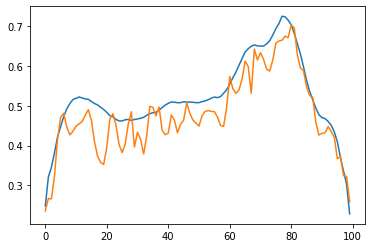

In [47]:
plt.plot(X[0, :, 0])
plt.plot(aug_X[:, 0])


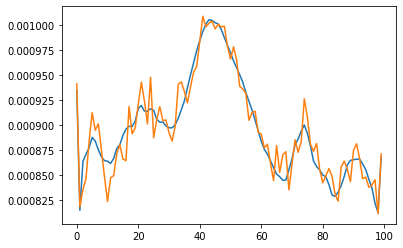

In [48]:
plt.plot(X[0, :, 24])
plt.plot(aug_X[:, 24])

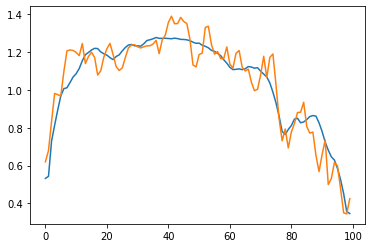

In [49]:
plt.plot(X[0, :, 48])
plt.plot(aug_X[:, 48])

(array([755.,   0.,  66.,   0.,   0.,   0.,   0., 743.,   0., 253.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

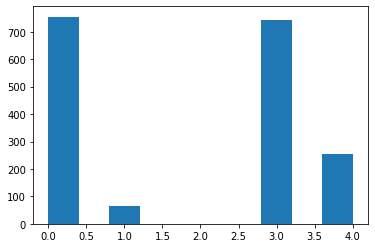

In [44]:
plt.hist(site)

In [ ]:
fig, ax = plt.subplots()
plt.plot(np.mean(X[site==0][:, :, 0], 0))
plt.plot(np.mean(X[site==3][:, :, 0], 0))
plt.plot(np.mean(X[site==4][:, :, 0], 0))

In [ ]:
fig, ax = plt.subplots()
plt.plot(np.mean(X[site==0][:, :, 24], 0))
plt.plot(np.mean(X[site==3][:, :, 24], 0))
plt.plot(np.mean(X[site==4][:, :, 24], 0))

In [ ]:
fig, ax = plt.subplots()
plt.plot(np.mean(X[site==0][:, :, 48], 0))
plt.plot(np.mean(X[site==3][:, :, 48], 0))
plt.plot(np.mean(X[site==4][:, :, 48], 0))